# RBM - Movies Recomendation with TensorFlow

---



# Nuova sezione

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import torch
import torch.nn.parallel
import torch.utils.data

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Load the data

In [ ]:
# Load data
df_ratings = pd.read_csv('ml-latest-small/ratings.csv')
df_ratings = df_ratings[['userId', 'movieId', 'rating']]


Of all the files provided by MovieLens we are interested in ratings.csv, as it contains the id of each
user and the rating that it gives to each movie, all in one table as follows:

In [ ]:
print(df_ratings.head())

   userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0


Now, this is not the matrix structure we need for RBM. We need each row to represent a single
user, and for each column to represent a movie. The value of the cells will be the user's rating to
that movie, and when a certain rating does not exist, we will assign a null value by default. To
move from the previous table to this new configuration we pivot the first table as follows.

In [ ]:
# Pivot table
df_input = pd.pivot_table(df_ratings, values='rating', index=['userId'], columns=['movieId'], aggfunc=np.sum)
print(df_input.head())

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     NaN     4.0     NaN     NaN     4.0     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     N

We can see how most movies don't have a rating, and they therefore have a null value associated
with them.
The next step is to replace null values with a numeric value that the RBM recognizes so as not to
consider during training the weights of a visible unit with respect to its hidden ones when that
visible unit has that value. This default value will be set to -1.

In [ ]:
# Deal with NaN
df_input = df_input.fillna(-1)
print(df_input.head())

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0    -1.0     4.0    -1.0    -1.0     4.0    -1.0    -1.0   
2          -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
3          -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
4          -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
5           4.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1          -1.0    -1.0  ...    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
2          -1.0    -1.0  ...    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
3          -1.0    -1.0  ...    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
4          -1.0    -1.0  ...    -1.0    -1.0    -1.0    -1.0    -1.0    -1

The next step, as usual, is to separate a train dataset from a test dataset. This will help us to first
train the RBM on train data. Next, we'll use the test data as input to the visible units and compare
the value predicted by the RBM against that original value to see if the reconstruction is good.
This comparison will only be made for visible units of test data that do not have null values. We
use 80% of the data for training and 20% for the final evaluation.

In [ ]:
# Train/Test split
X = df_input.sample(frac=1).round() # Round ratings
len_train = int(np.round(0.8*len(X)))
X_train = X.head(len_train)
X_test = X.tail(len_train)

The next step is to transform those arrays to the tensor format used by PyTorch. We do this as
follows.

In [ ]:
# Converting to PyTorch tensors
training_set = X_train.values
test_set = X_test.values
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

The next step in the initial processing is to move from the scale ratings 1 to 5 provided by
MovieLens to a binary scale, which represents the possible states that the RBM will have. This
way, a state of 0 will represent movies that the user didn't like, and a 1 that will. Similarly, the
RBM predictions for visible units over the null-values will have a 1 for the movies that the model
thinks that the user will like, and 0 for the other ones. The null variables are already with a value
of -1, so we don't need to change anything in them. Let's consider that a user likes a movie if their
rating has been greater than 3, and that they didn't like it if it was lower. We do all this directly as
follows thanks to PyTorch syntax.

In [ ]:
# Converting the ratings into binary ratings 1 (Liked) or 0 (Did not liked)
training_set[training_set == 1] = 0
training_set[training_set == 2] = 0
training_set[training_set >= 3] = 1
test_set[test_set == 1] = 0
test_set[test_set == 2] = 0
test_set[test_set >= 3] = 1

From this point on we will build the RBM. To do this, we'll create an RBM class in Python that has
different methods for executing the different parts of the algorithm. We're going to see one by one
each of them. This class will also receive a series of input hyperparameters during instantiation,
and will also initialize the NN's trainable parameters: the weights and biases of the two layers.
For this reason, the class and its constructor are as follows:

In [ ]:
class RBM():
  def __init__(self, nv, nh, batch_size, nb_epoch, k_steps, learning_rate,verbose):
    self.W = torch.randn(nh, nv)
    self.a = torch.randn(1, nh)
    self.b = torch.randn(1, nv)
    self.nh = nh
    self.nv = nv
    self.verbose = verbose
    self.batch_size = batch_size
    self.nb_epoch = nb_epoch
    self.k_steps = k_steps
    self.learning_rate = learning_rate

The nv and nh parameters represent the number of visible units and hidden units respectively.
Thus, the connection between them is defined with an array of dimension W weights [nh x nv].
Along with this, we define the bias vector of the hidden layer, a, and that of the visible layer, b.
The value of these parameters is defined with random values using the randn() function, which
returns random values taken from a normal distribution (between 0 and 1).
All other parameters correspond to the hyperparameters of the model and must be specified by
the user. These are:
▪ batch_size: the size of the batch size with which the NN is trained together.
▪ nb_epochs: Number of Epochs used.
▪ k_steps: The number of steps considered until comparing the reconstructed vector with
the input vector. For the equations seen within the course, we have considered k=1 and
compared the first sampling of visible units inferred from the RBM with the original input
units.
▪ learning_rate: The learning rate parameter considered in the weight and bias update.
The next step is to define the sampling equation for the hidden units. That is, given an input vector
of visible units, using the weights and bias, get the corresponding state of the hidden units.
Remembering the theory, this is calculated as follows

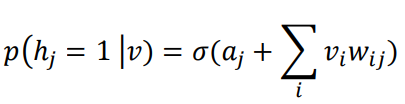

We have changed in the bias nomenclature: in the original equations it is b for the equation of the hidden
units and a for the visible ones. Here it is the other way around.

In this way, the conditioned probability that says how likely a particular hidden unit is worth 1 by
having the input vector information of visible units, is obtained by multiplying the vector of visible
units by the corresponding weights, adding the bias and applying the sigmoid function on the
result. Within PyTorch, it's as follows

In [ ]:
def sample_h(self, x):
 wx = torch.mm(x, self.W.t())
 activation = wx + self.a.expand_as(wx)
 p_h_given_v = torch.sigmoid(activation)
 return p_h_given_v, torch.bernoulli(p_h_given_v)

In that code snippet, we first multiply the input vector of the visible units (x) by the weight matrix,
to get that part of the equation (wx). Then we add the bias and then we get the probability that
the output state is 1 applying the sigmoid function. The function returns two values. On the one
hand, it returns the probability itself (p_h_given_v), and on the other hand returns the state
associated with that probability, using the Bernouilli distribution (torch.bernoulli(p_h_given_v)).
The latter serves simply for, for example, if the probability that the state is 1 is 0.3, return a 0 as
an associated state.
As an additional comment, the expand_as() function is used simply to express a tensor (in this
case a) with the dimension of another (in this case wx) in order to be able to do operations
between them, such as adding them up in this case.
Similarly, we define a function to get the reconstructed state of the units visible based on the value
that hidden units have with the same equation seen in the theory:

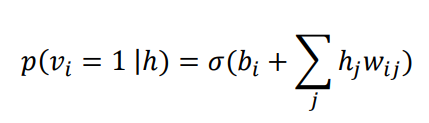


By taking this to code, we define the function as follows.

In [ ]:
def sample_v(self, y):
 wy = torch.mm(y, self.W)
 activation = wy + self.b.expand_as(wy)
 p_v_given_h = torch.sigmoid(activation)
 return p_v_given_h, torch.bernoulli(p_v_given_h)

The structure of the equation is similar to the one we have already explained for hidden units.
After that, we define a function to update the weights and biases of the NN. This is done using
the Contrastive Divergence (CD) algorithm. In theory we saw the following equation to update the
weights after a single step. The 𝜀 parameter represents the learning rate.

We implement this in code as follows:


In [ ]:
def update_weights(self, v0, vk, ph0, phk):
 learning_rate = self.learning_rate
 self.W += learning_rate*(torch.t(torch.mm(v0.t(), ph0) -torch.mm(vk.t(), phk)))
 self.b += learning_rate*(torch.sum((v0 - vk), 0))
 self.a += learning_rate*(torch.sum((ph0 - phk), 0))

With this function we update the weights and biases within the object we create when instantiating
the RBM() class. The function receives as input the start and end value of the visible units (v0
and vk) and the start and end of the hidden units (ph0 and phk). It is not necessary to use that
torch.sum() since we are adding 0 to the bias, but we leave it in case we want to generalize the
code and add a fixed offset on those biases in each update

The following function that we will define will take care of the entire process of executing the
algorithm, including the use of the parameters of the batch_size and the epochs considered, as
well as the number of steps with k_steps. Let's first show the function to execute it, and we'll
comment on it in more detail.

In [ ]:
def train(self, training_set):
 batch_size = self.batch_size
 nb_epoch = self.nb_epoch
 k_steps = self.k_steps
 verbose = self.verbose

 # Training the RBM
 for epoch in range(1, nb_epoch + 1):
  train_loss = 0
  s = 0
  nb_users = len(training_set)
 for id_user in range(0, nb_users - batch_size, batch_size):
  vk = training_set[id_user:id_user+batch_size]
  v0 = training_set[id_user:id_user+batch_size]
  ph0,_ = self.sample_h(v0)
 for k in range(k_steps):
  _,hk = self.sample_h(vk)
  _,vk = self.sample_v(hk)
  vk[v0<0] = v0[v0<0]
 phk,_ = self.sample_h(vk)
 self.update_weights(v0, vk, ph0, phk)
 train_loss += torch.mean(torch.abs(v0[v0>=0] - vk[v0>=0]))
 s += 1.

 if verbose:
  print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))

The number of epochs defines the iterations with which to repeat the process, with the same input
data, to update the weights and biases.
Within each epoch, a subset of input user data is considered together for an update based on the
size of the batch_size. These will be multiplied relative to the weight matrix and bias vector (so
that each row, which represents a user, is multiplied entirely by those arrays) to jointly generate
the same number of corresponding hidden states, and compute the cost function with all that
dataset considered.
For visible units, we first sample and get the corresponding state of the hidden ones, to iteratively
perform the k steps. Each of the k steps samples the hidden state with the state value of the
hidden units from step k-1 above.

An important point of the algorithm is vk[v0<0] = v0[v0<0]. With this we treat the case of visible
units with null values. What we do is that for units with value -1 (null value) we keep the original
value they had. This way, when there are units with null values, we will not update their
corresponding weights.
After completing the k steps, the last visible vector reconstructed along with the corresponding
hidden state, is used to calculate the negative gradient, and thus update the weights.
Finally, we calculate the value of the cost function, which will simply be the mean difference
between the array of input states for that batch and the reconstructed ones, also ignoring in that
comparison the units with states with -1 (and only seeing the difference in those that have a known
value).
Next, we define a function to evaluate the RBM. That is, by receiving the test input data, the
reconstructions are compared without updating the weights and the difference is measured for
visible units that do not have null values. This would look like this:

In [ ]:
def evaluate(self, test_set):
 verbose = self.verbose
 nb_users = len(test_set)

 # Testing the RBM
 test_loss = 0
 s = 0.
 for id_user in range(nb_users):
  v = training_set[id_user:id_user+1]
  vt = test_set[id_user:id_user+1]
  if len(vt[vt>=0]) > 0:
    _,h = self.sample_h(v)
    _,v = self.sample_v(h)
    test_loss += torch.mean(torch.abs(vt[vt>=0] - v[vt>=0]))
    s += 1.
  if verbose:
    print('test loss: '+str(test_loss/s))
 return test_loss/s

As we see, the function iterates for each user in the input test_set dataset. First, it ensures that
there is at least one rated movie, and if there is one step in the RBM to get the reconstructed input
vector. The value of the units without null values is compared, and the mean of the difference
between all units is made. This is repeated for each user, and then the mean of the difference
means is returned as a metric.
One last feature we incorporate is to get the predictions for a user. This function simply receives
an input vector from visible units and returns the corresponding reconstructed vector, including
new values for visible units with null values. The function is as follows:

In [ ]:
def predict(self, v_user):
 _,h = self.sample_h(v_user)
 _,v = self.sample_v(h)
 return v

With that, the final class for the RBM would look like this:

In [ ]:
#Class that defines the behavior of the RBM
class RBM(object):

    def __init__(self, input_size, output_size, lr=1.0, batchsize=100):
        """
        m: Number of neurons in visible layer
        n: number of neurons in hidden layer
        """
        #Defining the hyperparameters
        self._input_size = input_size #Size of Visible
        self._output_size = output_size #Size of outp
        self.learning_rate = lr #The step used in gradient descent
        self.batchsize = batchsize #The size of how much data will be used for training per sub iteration

        #Initializing weights and biases as matrices full of zeroes
        self.w = tf.zeros([input_size, output_size], np.float32) #Creates and initializes the weights with 0
        self.hb = tf.zeros([output_size], np.float32) #Creates and initializes the hidden biases with 0
        self.vb = tf.zeros([input_size], np.float32) #Creates and initializes the visible biases with 0


    #Forward Pass
    def prob_h_given_v(self, visible, w, hb):
        #Sigmoid
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    #Backward Pass
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    #Generate the sample probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))

    #Training method for the model
    def train(self, X, epochs=10):

        loss = []
        for epoch in range(epochs):
            #For each step/batch
            for start, end in zip(range(0, len(X), self.batchsize),range(self.batchsize,len(X), self.batchsize)):
                batch = X[start:end]

                #Initialize with sample probabilities

                h0 = self.sample_prob(self.prob_h_given_v(batch, self.w, self.hb))
                v1 = self.sample_prob(self.prob_v_given_h(h0, self.w, self.vb))
                h1 = self.prob_h_given_v(v1, self.w, self.hb)

                #Create the Gradients
                positive_grad = tf.matmul(tf.transpose(batch), h0)
                negative_grad = tf.matmul(tf.transpose(v1), h1)

                #Update learning rates
                self.w = self.w + self.learning_rate *(positive_grad - negative_grad) / tf.dtypes.cast(tf.shape(batch)[0],tf.float32)
                self.vb = self.vb +  self.learning_rate * tf.reduce_mean(batch - v1, 0)
                self.hb = self.hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)

            #Find the error rate
            err = tf.reduce_mean(tf.square(batch - v1))
            print ('Epoch: %d' % epoch,'reconstruction error: %f' % err)
            loss.append(err)

        return loss

    #Create expected output for our DBN
    def rbm_output(self, X):
        out = tf.nn.sigmoid(tf.matmul(X, self.w) + self.hb)
        return out

    def rbm_reconstruct(self,X):
        h = tf.nn.sigmoid(tf.matmul(X, self.w) + self.hb)
        reconstruct = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.w)) + self.vb)
        return reconstruct

After implementing the class, we can train the RBM on the train data. To do this, we first define
the necessary hyperparameters.

In [ ]:
# Hyperparameters
nv = len(training_set[0])
nh = 100
batch_size = 100
nb_epoch = 10
k_steps = 10
learning_rate = 1
verbose = True

All parameters can be defined with the values we want, except for the visible units, which
necessarily corresponds to the number of movies that are available.
With this, we train the RBM.

In [ ]:
# Train model
rbm = RBM(nv, nh, batch_size, nb_epoch, k_steps, learning_rate, verbose)
rbm.train(training_set)

epoch: 1 loss: tensor(0.4935)
epoch: 1 loss: tensor(0.4827)
epoch: 1 loss: tensor(0.4364)
epoch: 1 loss: tensor(0.4020)
epoch: 2 loss: tensor(0.2718)
epoch: 2 loss: tensor(0.2797)
epoch: 2 loss: tensor(0.2617)
epoch: 2 loss: tensor(0.2504)
epoch: 3 loss: tensor(0.2397)
epoch: 3 loss: tensor(0.2475)
epoch: 3 loss: tensor(0.2431)
epoch: 3 loss: tensor(0.2362)
epoch: 4 loss: tensor(0.2385)
epoch: 4 loss: tensor(0.2491)
epoch: 4 loss: tensor(0.2404)
epoch: 4 loss: tensor(0.2313)
epoch: 5 loss: tensor(0.2316)
epoch: 5 loss: tensor(0.2498)
epoch: 5 loss: tensor(0.2397)
epoch: 5 loss: tensor(0.2268)
epoch: 6 loss: tensor(0.2224)
epoch: 6 loss: tensor(0.2360)
epoch: 6 loss: tensor(0.2308)
epoch: 6 loss: tensor(0.2211)
epoch: 7 loss: tensor(0.2596)
epoch: 7 loss: tensor(0.2764)
epoch: 7 loss: tensor(0.2626)
epoch: 7 loss: tensor(0.2496)
epoch: 8 loss: tensor(0.2230)
epoch: 8 loss: tensor(0.2374)
epoch: 8 loss: tensor(0.2315)
epoch: 8 loss: tensor(0.2215)
epoch: 9 loss: tensor(0.2249)
epoch: 9 l

Apparently, they are not bad results; the value of the cost function is relatively low. The next point
is to evaluate the model on the test data. We do this directly by calling the evaluation function that
we defined in the class and using the test data.

In [ ]:
# Evaluation
rbm.evaluate(test_set)

test loss: tensor(0.2198)


tensor(0.2198)

As a final step, we will see the movies that the RBM would recommend to a specific user as it
estimates that they will like them. To do this, we're going to first get the vector of visible units
reconstructed for a user, and then we'll see which movies correspond to visible units that in the
original vector had a value of -1 (no rating) and now have 1 in the reconstructed vector (meaning
that the user may like them). To do this we do the following:

In [ ]:
# Obtain an individual prediction
v_test = test_set[0:1]
v_pred = rbm.predict(v_test)
# Check movie for that prediction
id_movies = ([v_pred==1][0][0]) & ([v_test==-1][0][0])
id_movies = id_movies.tolist()
# Combine with movie titles and see results for units with missing values
df_recom = pd.DataFrame({'id_check':id_movies})
df_movies = pd.read_csv('ml-latest-small/movies.csv')
df_recom = df_recom.reset_index().rename(columns={'index':'movieId'}).merge(df_movies)


With this, we are defining in id_movies a vector with boolean values (True/False) with True only
for those movies that originally had a value of -1 and now have it of 1 (the ones we want to
recommend). For all other cases we have False (both for movies already viewed, and for movies
that do not see with a value of 0 in the rebuild). All this shows us the following example output of
10 films that can be recommended:

In [ ]:
print("Recommended movies: ")
print(df_recom[df_recom['id_check']==True]['title'].head(10))

Recommended movies: 
0                       Toy Story (1995)
2                Grumpier Old Men (1995)
3               Waiting to Exhale (1995)
4     Father of the Bride Part II (1995)
5                            Heat (1995)
6                         Sabrina (1995)
7                    Tom and Huck (1995)
8                    Sudden Death (1995)
9                       GoldenEye (1995)
11    Dracula: Dead and Loving It (1995)
Name: title, dtype: object
